In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-darkgrid')

pd.read_csv('datasets/train_v2_cleaned_damage_inc.csv')

In [2]:
df.shape

(5000, 67)

In [3]:
df['outcome_damage_inc'].value_counts()

0.0    3723
1.0    1277
Name: outcome_damage_inc, dtype: int64

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X = df.drop(['outcome_damage_inc'],1)
y = df['outcome_damage_inc']

X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
X_train, X_val, y_train, y_val = train_test_split(X_trainval,y_trainval, test_size=0.2, random_state=1234)

In [5]:
num_feat = X.select_dtypes(include=['int64', 'float64']).columns
scaler = StandardScaler()
X_train_stand = X_train.copy()
X_trainval_stand = X_trainval.copy()
X_val_stand = X_val.copy()

X_test_stand = X_test.copy()
X_train_stand[num_feat] = scaler.fit_transform(X_train_stand[num_feat])
X_val_stand[num_feat] = scaler.transform(X_val_stand[num_feat])
X_trainval_stand[num_feat] = scaler.transform(X_trainval_stand[num_feat])
X_test_stand[num_feat] = scaler.transform(X_test_stand[num_feat])

In [6]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(C=10000, max_iter=200) 
logreg.fit(X_train_stand, y_train)

LogisticRegression(C=10000, max_iter=200)

In [7]:
print(logreg.score(X_train_stand, y_train))
print(logreg.score(X_test_stand, y_test))

0.751875
0.762


In [8]:
y_test_pred = logreg.predict(X_test_stand)
y_test_pred_prob = logreg.predict_proba(X_test_stand)

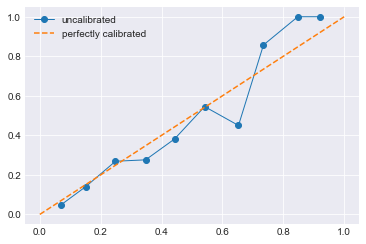

In [9]:
from sklearn.calibration import calibration_curve
y_pred_val_prob = logreg.predict_proba(X_val_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()

In [10]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86       752
         1.0       0.59      0.13      0.21       248

    accuracy                           0.76      1000
   macro avg       0.68      0.55      0.54      1000
weighted avg       0.73      0.76      0.70      1000



In [11]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
isotonic = CalibratedClassifierCV(logreg, cv='prefit', method='isotonic')
isotonic.fit(X_val_stand, y_val)

CalibratedClassifierCV(base_estimator=LogisticRegression(C=10000, max_iter=200),
                       cv='prefit', method='isotonic')

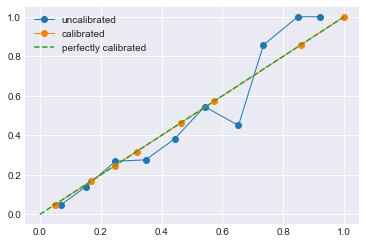

In [12]:
from sklearn.calibration import calibration_curve

y_val_pred_prob_c = isotonic.predict_proba(X_val_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_val,y_val_pred_prob_c[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')

plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')

plt.legend()
plt.show()

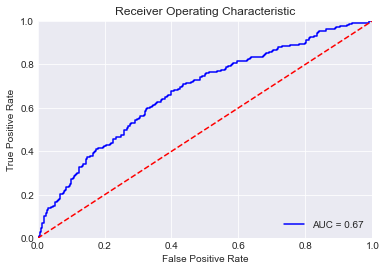

In [13]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
preds = y_test_pred_prob[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
roc_auc = metrics.auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [14]:
y_pred = logreg.predict(X_test_stand)
y_pred_c = isotonic.predict(X_test_stand)

print(classification_report(y_test, y_pred))
print(classification_report(y_test, y_pred_c))

              precision    recall  f1-score   support

         0.0       0.77      0.97      0.86       752
         1.0       0.59      0.13      0.21       248

    accuracy                           0.76      1000
   macro avg       0.68      0.55      0.54      1000
weighted avg       0.73      0.76      0.70      1000

              precision    recall  f1-score   support

         0.0       0.75      0.99      0.86       752
         1.0       0.33      0.01      0.02       248

    accuracy                           0.75      1000
   macro avg       0.54      0.50      0.44      1000
weighted avg       0.65      0.75      0.65      1000



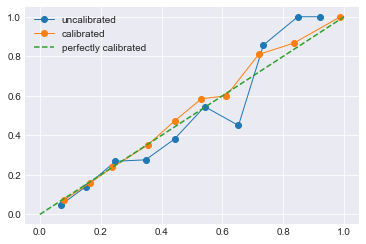

              precision    recall  f1-score   support

         0.0       0.75      0.99      0.86       752
         1.0       0.33      0.01      0.02       248

    accuracy                           0.75      1000
   macro avg       0.54      0.50      0.44      1000
weighted avg       0.65      0.75      0.65      1000

              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86       752
         1.0       0.57      0.09      0.16       248

    accuracy                           0.76      1000
   macro avg       0.67      0.54      0.51      1000
weighted avg       0.72      0.76      0.69      1000



In [15]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
logreg2 = LogisticRegression(C=10000, max_iter=1000) 
isotonic2 = CalibratedClassifierCV(logreg2, cv=3, method='isotonic')
isotonic2.fit(X_trainval_stand, y_trainval)


# The calibration plot
y_val_pred_prob_c2 = isotonic2.predict_proba(X_trainval_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_trainval,y_val_pred_prob_c2[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')
plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()
plt.show()

y_pred_c2 = isotonic2.predict(X_test_stand)
print(classification_report(y_test, y_pred_c))
print(classification_report(y_test, y_pred_c2))

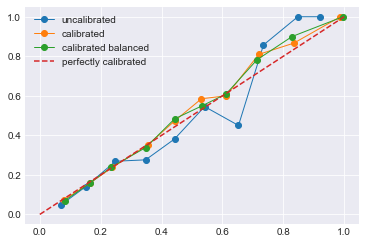

              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86       752
         1.0       0.57      0.09      0.16       248

    accuracy                           0.76      1000
   macro avg       0.67      0.54      0.51      1000
weighted avg       0.72      0.76      0.69      1000

              precision    recall  f1-score   support

         0.0       0.77      0.98      0.86       752
         1.0       0.58      0.09      0.15       248

    accuracy                           0.76      1000
   macro avg       0.67      0.53      0.51      1000
weighted avg       0.72      0.76      0.68      1000



In [16]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
logreg_balanced = LogisticRegression(C=10000, class_weight='balanced', max_iter=1000) 
isotonic3 = CalibratedClassifierCV(logreg_balanced, cv=3, method='isotonic')
isotonic3.fit(X_trainval_stand, y_trainval)

# The calibration plot
y_val_pred_prob_c3 = isotonic3.predict_proba(X_trainval_stand)

fop, mpv = calibration_curve(y_val,y_pred_val_prob[:,1],n_bins=10)
fop_c, mpv_c = calibration_curve(y_trainval,y_val_pred_prob_c2[:,1],n_bins=10)
fop_c3, mpv_c3 = calibration_curve(y_trainval,y_val_pred_prob_c3[:,1],n_bins=10)

plt.plot(mpv,fop, marker='o', linewidth=1, label='uncalibrated')
plt.plot(mpv_c,fop_c, marker='o', linewidth=1, label='calibrated')
plt.plot(mpv_c3,fop_c3, marker='o', linewidth=1, label='calibrated balanced')

plt.plot([0,1],[0,1],linestyle='--', label='perfectly calibrated')
plt.legend()
plt.show()

y_pred_c3 = isotonic3.predict(X_test_stand)
print(classification_report(y_test, y_pred_c2))
print(classification_report(y_test, y_pred_c3))

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

prec_scorer = make_scorer(metrics.accuracy_score)
# other possibilities are metrics.recall_score, metrics.average_precision, ...

C = [round(x,5) for x in np.linspace(start = 0.0001, stop = 10, num = 1000)]
#penalty = ['l1', 'l2']
class_weight = ['balanced']
random_grid = {'C': C,    
               'class_weight': class_weight}

#Designing polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
X_trainval_poly = poly.fit_transform(X_trainval_stand)
X_test_poly = poly.transform(X_test_stand)

# The object to fit the model
logreg = LogisticRegression( max_iter=1000) 

# object for the randomised search
log_random = RandomizedSearchCV(estimator = logreg, param_distributions = random_grid,
                                scoring=prec_scorer, n_iter = 100,
                               cv = 3, verbose=2,  n_jobs=-1)

#Fitting model (model+ calibration)
log_random.fit(X_trainval_poly, y_trainval)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


RandomizedSearchCV(cv=3, estimator=LogisticRegression(max_iter=1000),
                   n_iter=100, n_jobs=-1,
                   param_distributions={'C': [0.0001, 0.01011, 0.02012, 0.03013,
                                              0.04014, 0.05015, 0.06016,
                                              0.07017, 0.08018, 0.09019, 0.1002,
                                              0.11021, 0.12022, 0.13023,
                                              0.14024, 0.15025, 0.16026,
                                              0.17027, 0.18028, 0.19029, 0.2003,
                                              0.21031, 0.22032, 0.23033,
                                              0.24034, 0.25035, 0.26036,
                                              0.27037, 0.28038, 0.29039, ...],
                                        'class_weight': ['balanced']},
                   scoring=make_scorer(accuracy_score), verbose=2)

In [18]:
log_random.best_params_

{'class_weight': 'balanced', 'C': 0.66075}

c:\python38\lib\site-packages\pandas\core\indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


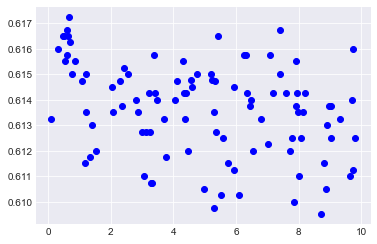

In [19]:
out2 = pd.DataFrame(log_random.cv_results_)

#Have to replace the None values with something else, or it wont's make the plots
res = [i for i in range(len(out2['param_class_weight'])) if out2['param_class_weight'][i] == None] 
out2['param_class_weight'].iloc[res] = "No"

xlabel_names = ['param_C','param_class_weight']


plt.scatter(out2['param_C'], out2['mean_test_score'], c='blue');

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer

prec_scorer = make_scorer(metrics.accuracy_score)
# other possibilities are metrics.recall_score, metrics.average_precision, ...

C = [round(x,5) for x in np.linspace(start = 0.0001, stop = 0.5, num = 100)]
class_weight = ['balanced']

random_grid = {'C': C,
               'class_weight': class_weight}

# The object to fit the model
logreg_balanced = LogisticRegression( max_iter=1000) 

# object for the randomised search
log_grid = GridSearchCV(estimator = logreg_balanced, param_grid = random_grid,
                                scoring=prec_scorer  , cv = 3, verbose=2,  n_jobs=-1)
isotonic_log = CalibratedClassifierCV(log_grid, cv=3, method='isotonic')

#Fitting model (model+ calibration)
isotonic_log.fit(X_trainval_poly, y_trainval)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits
Fitting 3 folds for each of 100 candidates, totalling 300 fits


CalibratedClassifierCV(base_estimator=GridSearchCV(cv=3,
                                                   estimator=LogisticRegression(max_iter=1000),
                                                   n_jobs=-1,
                                                   param_grid={'C': [0.0001,
                                                                     0.00515,
                                                                     0.0102,
                                                                     0.01525,
                                                                     0.0203,
                                                                     0.02535,
                                                                     0.0304,
                                                                     0.03545,
                                                                     0.0405,
                                                                     0.04555,
          

In [21]:
isotonic_log.score(X_test_poly, y_test)

0.752

In [22]:
y_pred_poly = isotonic_log.predict(X_test_poly)
print(classification_report(y_test, y_pred_poly))

              precision    recall  f1-score   support

         0.0       0.75      0.99      0.86       752
         1.0       0.50      0.02      0.04       248

    accuracy                           0.75      1000
   macro avg       0.63      0.51      0.45      1000
weighted avg       0.69      0.75      0.65      1000



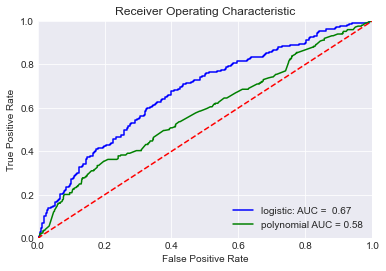

In [23]:
import sklearn.metrics as metrics
# calculate the fpr and tpr for all thresholds of the classification
preds = y_test_pred_prob[:,1]
preds_poly = isotonic_log.predict_proba(X_test_poly)[:,1]

fpr, tpr, threshold = metrics.roc_curve(y_test, preds)
fpr_p, tpr_p, threshold = metrics.roc_curve(y_test, preds_poly)

roc_auc = metrics.auc(fpr, tpr)
roc_auc_p = metrics.auc(fpr_p, tpr_p)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'logistic: AUC =  %0.2f' % roc_auc)
plt.plot(fpr_p, tpr_p, 'g', label = 'polynomial AUC = %0.2f' % roc_auc_p)

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()